# Music genre classifier

Apply a KNN classifier to the GTZAN Music Genres dataset of audio files to predict the genre of a song.

This notebook was built from a tutorial on [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2022/03/music-genre-classification-project-using-machine-learning-techniques/), with a few small changes for better readbility.

In [52]:
from python_speech_features import mfcc
from python_speech_features import logfbank  # copilot
from python_speech_features import delta  # copilot

from tempfile import TemporaryFile

import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import pickle
import random
import scipy.io.wavfile as wav
import sys

# from sklearn import preprocessing # copilot vvvvv
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn import svm
# from sklearn import tree
# from sklearn import neighbors
# from sklearn import ensemble
# from sklearn import linear_model
# from sklearn import neural_network
# from sklearn import naive_bayes
# from sklearn import discriminant_analysis
# from sklearn import model_selection
# from sklearn import feature_selection
# from sklearn import metrics
# from sklearn import decomposition
# from sklearn import pipeline  # copilot^^^^^^



In [67]:
# # define a function to get the distance between feature neighbors and find neighbors
# def distance(instance1, instance2):
#     dist = np.linalg.norm(instance1 - instance2) # Euclidean distance
#     return dist
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]

    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2 - mm1).transpose(), np.linalg.inv(cm2)), mm2 - mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k

    return distance


def get_neighbors(training_set, instance, k, randomization=0.0):
    distances = []
    for x in range(len(training_set)):
        # dist = distance(training_set[x], instance, k)
        dist = distance(training_set[x], instance, k) + distance(instance,training_set[x],k)
        
        # print("dist: ", dist)
        
        # add randomization to distance
        dist += random.random() * randomization
        distances.append((training_set[x], dist))

    distances.sort(key=operator.itemgetter(1)) # store as priority queue
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [62]:
## need a two dimensional array of features and covariances
# # test get_neighbors logic (sorted results)
# dummy_train_set = [
#     [1, 2, 0, 0, 0, 0, 0],
#     [1, 2, 3, 4, 5, 6, 7],
#     [1, 2, 3, 4, 5, 6, 0],
#     [1, 0, 0, 0, 0, 0, 0],
#     [1, 2, 3, 0, 0, 0, 0],
#     [1, 2, 3, 4, 5, 0, 0],
#     [1, 2, 3, 4, 0, 0, 0],
# ]

# dummy_target = [0, 0, 0, 0, 0, 0, 0]


# actual_output = get_neighbors(dummy_train_set, dummy_target, 3, 0.0)

# expected_output = np.array([
#     [1, 0, 0, 0, 0, 0, 0],
#     [1, 2, 0, 0, 0, 0, 0],
#     [1, 2, 3, 0, 0, 0, 0]
#     ])

# assert np.equal(actual_output, expected_output).all(), "Test failed!"


In [ ]:
# function to identify the nearest neighbor
def nearest_class(neighbors):
    class_votes = {}

    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        if response in class_votes:
            class_votes[response] += 1
        else:
            class_votes[response] = 1

    # sort the dictionary by value, in descending order (largest first)
    sorted_votes = sorted(class_votes.items(), key=operator.itemgetter(1), reverse=True)

    return sorted_votes[0][0] # single-class  # for multi-class, rm [0][0]

In [ ]:
def nearest_neighbor_classify_with_confidence(training_set, training_labels, new_instance, num_neighbors, randomization=0.0):
    """Generated by copilot. Looked interested but not worth exporing now bc of _labels"""
    neighbors = get_neighbors(training_set, new_instance, num_neighbors, randomization)
    counts = np.bincount(training_labels[neighbors[:, 0].astype(int)])
    return np.argmax(counts), np.max(counts) / np.sum(counts)


In [ ]:
# evaluation
def get_accuracy(test_set, predictions):
    correct = 0
    for x in range(len(test_set)):
        if test_set[x][-1] == predictions[x]:
            correct += 1
    return (correct / float(len(test_set))) * 1.0

In [ ]:
# test get_accuracy logic
dummy_test_set = [
    [1, 2, 0, 0, 0, 0, 0],
    [1, 2, 3, 4, 5, 6, 7],
]

dummy_predictions = [0, 0]

actual_output = get_accuracy(dummy_test_set, dummy_predictions)
expected_output = 0.5

assert actual_output == expected_output, "Test failed!"

In [ ]:
# test get_accuracy logic
dummy_test_set = [
    [1, 2, 0, 0, 0, 0, 0],
    [1, 2, 3, 4, 5, 6, 7],
    [1, 2, 3, 4, 5, 6, 0],
]

dummy_predictions = [0, 0, 1]

actual_output = get_accuracy(dummy_test_set, dummy_predictions)
expected_output = 1/3.0

assert actual_output == expected_output, "Test failed!"

In [ ]:
# test get_accuracy logic (complex)
dummy_test_set = [
    [1, 2, 0, 0, 0, 0, 0],
    [1, 2, 3, 4, 5, 6, 7],
    [1, 2, 3, 4, 5, 6, 0],
    [1, 0, 0, 0, 0, 0, 0],
    [1, 2, 3, 0, 0, 0, 0],
    [1, 2, 3, 4, 5, 0, 0],
    [1, 2, 3, 4, 0, 0, 0],
]

dummy_predictions = [0, 0, 0, 0, 0, 3, 0]

actual_output = get_accuracy(dummy_test_set, dummy_predictions)
expected_output = 0.7142857142857143

assert actual_output == expected_output, "Test failed!"

### Mel frequency cepstral coefficients (MFCCs)
Audio features are classified into 3 categories: high-level, mid-level, and low-level features. 
- High-level features: genre, mood, instrumentation, rhythm, lyrics, chords
- Mid-level features: beat-level attributes, pitch-like fluctuation, MFCCs
- Low-level features: [enery](https://help.spotontrack.com/article/what-do-the-audio-features-mean#:~:text=Energy,scores%20low%20on%20the%20scale.), [zero-crossing rate](https://en.wikipedia.org/wiki/Zero-crossing_rate#:~:text=The%20zero%2Dcrossing%20rate%20), timbre, loudness, etc.

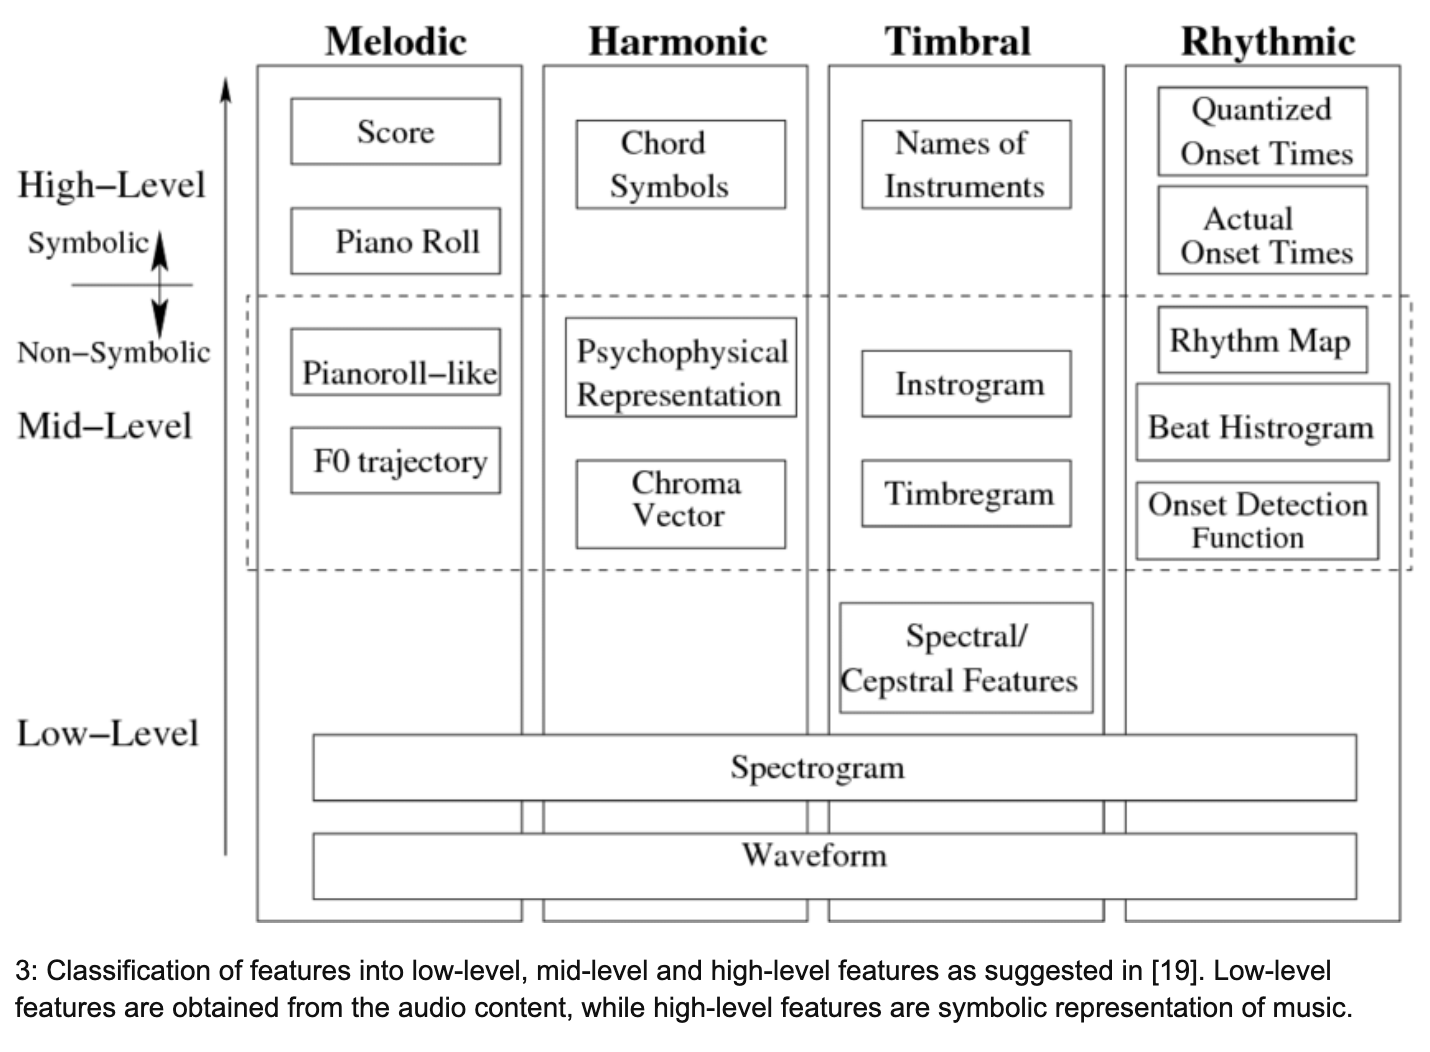
([Ramaseshan, 2013](https://www.researchgate.net/figure/Classification-of-features-into-low-level-mid-level-and-high-level-features-as_fig2_259479391))

[Mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (MFCCs) are coefficients that collectively make up an MFC.
They are derived from a type of [cepstral](https://en.wikipedia.org/wiki/Cepstrum) representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). 
The difference between the cepstrum and the mel-frequency cepstrum is, in the MFC the **frequency bands are equally spaced on the mel scale**, which approximates the **human auditory system's response** more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression that might potentially reduce the transmission bandwidth and the storage requirements of audio signals.


The process of extracting MFCCs (mid-level and low-level features) is as follows:
1. Take the Fourier transform of (a windowed excerpt of) a signal.
2. Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
3. Take the logs of the powers at each of the mel frequencies.
4. Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
5. The MFCCs are the amplitudes of the resulting spectrum.





In [ ]:
len(os.listdir("../../../../data/gtzan_music_dataset/genres_original/"))

10

In [ ]:
data_dir = "../../../../data/gtzan_music_dataset/genres_original"

# get all the files from the dataset
f = open('music.dat', 'wb')
i = 0

for folder in os.listdir(data_dir):
    print(folder)
    i += 0
    if i > 10:  # only 10 genres, anything else is not music
        break
    
    for file in os.listdir(data_dir + "/" + folder):  
        # print(file)
        try:
            (rate, sig) = wav.read(data_dir + "/" + folder + "/" + file)
            mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)  # what does appendEnergy do?
            covariance = np.cov(np.matrix.transpose(mfcc_feat)) # covariance = second moments of a distribution
            mean_matrix = mfcc_feat.mean(0)  # mean along the axis 0 (rows?)
            feature = (mean_matrix, covariance, i)  # i is the label
            pickle.dump(feature, f)  # dump the data into the file
        except ValueError as e:
            print("Got an exception in folder:", folder, "file:", file) # some files are corrupted
            continue

f.close()



pop
metal
disco
blues
reggae
classical
rock
hiphop
country
jazz
Got an exception in folder: jazz file: jazz.00054.wav


In [ ]:
# train test split 

def load_and_split_dataset(filename, split):
    dataset = []  # all the data
    train = []
    test = []

    with open(filename, 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break

    for x in range(len(dataset)):
        if random.random() < split:  # split is the percentage of the training set
         train.append(dataset[x])
         print(dataset[x].shape)
        else:
            test.append(dataset[x])

    return dataset, train, test


dataset, train, test = load_and_split_dataset('music.dat', 0.66)


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
# make sure distance is loaded
import inspect
lines = inspect.getsource(distance)
print(lines)

def distance(instance1, instance2):
    dist = np.linalg.norm(instance1 - instance2) # Euclidean distance
    return dist



In [ ]:
train[0][0].shape, test[0][0].shape

((13,), (13,))

In [ ]:
len(train[0]), len(test[0])

(3, 3)

In [ ]:
len(test[0])

3

In [ ]:
train[0][1].shape, test[0][1].shape

((13, 13), (13, 13))

In [73]:
# make predictions using KNN
length = len(test)
predictions = []

k = 5  # top 5 neighbors

for x in range(length):  
    # get_neighbors return top-k neighboring arrays to the test[x] array
    # nearest_class returns the class of the nearest neighbor

    # for each row in our test set,
    # get the top-k neighbors from the training set
    # store and count the class of the nearest neighbors
    # the class with the highest count is the prediction
    neighbors = get_neighbors(train, test[x], k, 0.2)
    predictions.append(nearest_class(neighbors))


In [74]:
get_accuracy(test, predictions)

1.0

In [75]:
# something seems strange here, why is it exactly 1?

In [78]:
# evaluate the model
directory = "../../../../data/gtzan_music_dataset/genres_original/"

results = {}
i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1
    print(i, folder)
    if i ==5:
        break
    

2 pop
3 metal
4 disco
5 blues
